# 0.0 Tabel of Contents

[Fillout NA](#1.5-Fillout-NA) <br>
[Numerical Attibutes](#1.7.1-Numerical-Attributes)

# 0. IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
import math
import datetime as datetime

from scipy import stats
from IPython.display import Image
from IPython.display import HTML

## 0.1. Helper Functions

In [2]:
def cramer_v(x,y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    # é necessário os valores da cm como uma matriz
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 =stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    # o comando mágico abaixo é para o kernel XPython mostrar os gráficos na célula
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    # para o pandas mostrar o dataframe completo, sem restrição no número de colunas a ser exibido, posso alterar a seguitne opção:
    pd.set_option('max_columns', None, "max_rows", 50)
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False)
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on = 'Store' )

# 1.0. DESCRICAO DOS DADOS

In [5]:
# é interessante copiar o df no início de cada seção para evitar que, caso seja alterado o conteúdo do df, não seja necessário rodar todo o código novamente
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
# imprimir o número de linhas e colunas usando 2 maneiras de interpolar strings
print(f'Number of Rows: {df1.shape[0]}')
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
# inicialmente, o date é object
# deve-se alterar o tipo do date
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

Existem 3 métodos principais: <br>
    - Removo todas as linhas com NA: método possui a imensa desvantagem de perder muita informação <br>
    - Uso algum algoritmo para preencher os dados NA, como média, mediana ou algum ML para estimar os valores <br>
    - Entender a razão pela qual é NA; sempre devo começar por este método, pois eventualmente o NA era esperado
    

In [10]:
#competition_distance: distance in meters to the nearest competitor store

# o código abaixo revela que existem 3 lojas (622, 291 e 879) que possuem esta coluna em branco
stores = df1[df1["competition_distance"].isna()]["store"].value_counts()
display(stores)
print("\n")

# o código abaixo revela que existem as mesmas quantidades de linhas que trazem os dados destas stores em relação
# à quantidade de linhas com o valor da distância do competidor mais próximo igual a NA
# com isso conclui-se que todas as linhas dessas 3 stores estão, de fato, com o valor NA para competition_distance
for store in stores.index:
    print(df1[df1["store"] == store].shape[0])
print("\n")  
    
# portanto, é razoável assumir que este valor NA para a competition distance significa que não há loja competidora próxima
# será então substituída por um vlaor muito maior que a distância máxima
# antes, precisamos saber o a distância máxima presente no dataset
print((df1["competition_distance"].max()))
print("\n") 

# sabendo que a distância máximo é 75860, podemos substituir por 200.000, por exemplo
df1["competition_distance"] = df1["competition_distance"].fillna(200000)

# finalmente, checando se atribuiu corretamente
print("Após a modificação, agora há " + str(df1["competition_distance"].isna().sum()) + " valor faltante")

622    942
291    942
879    758
Name: store, dtype: int64



942
942
758


75860.0


Após a modificação, agora há 0 valor faltante


In [11]:
#competition_open_since_month:  gives the approximate year and month of the time the nearest competitor was opened

# para a primeira interação do CRISP, para aquelas lojas que eu não tenho a informação sobre quando a loja competidora abriu,
# vou simplesmente alocar o mesmo mês da linha de venda. Mesmo não sendo lógico, se for preciso na segunda interação do método CRISP
# poderei alterar esta atribuição.
# um motivo para essa suposição é que o mês e ano que uma loja competidora abriu pode significar um evento no comportamento de vendas
# tal evento pode ser detectado lá no feature selection
# logo, se o mês e ano da loja competidora "acompanham" o mês e ano da data da venda, não haverá nenhuma consequência nas vendas para as linhas que
# inicialmente estavam NA


x = lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"]
df1["competition_open_since_month"] = df1.apply(x, axis=1)

# o mesmo raciocínio para o "competition_open_since_month" vale para o "competition_open_since_year", promo2_since_week e promo2_since_year
#competition_open_since_year
x = lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"]
df1["competition_open_since_year"] = df1.apply(x, axis=1)

#promo2_since_week
x = lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"]
df1["promo2_since_week"] = df1.apply(x, axis=1)

#promo2_since_year
x = lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"]
df1["promo2_since_year"] = df1.apply(x, axis=1)


In [12]:
#promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
#E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# para a primeira rodada do CRISP, será atribuído o valor 0 (zero) para os dados faltantes da coluna "promo_interval"
df1["promo_interval"].fillna(0, inplace = True)

# a seguir, será verificado se o mês da data da linha é mês de início de rodada da promo2 e atribuído à nova coluna "is_promo:
# 0 (quando não é mês de de início) ou 1 (quando é mês de início)
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug",9: "Sept", 10: "Oct", 11: "Nov",12: "Dec"}
df1["month_map"] = df1["date"].dt.month.map(month_map)

# escrevi 2 maneiras de executar a função que popula a nova coluna "is_promo"
# a primeira demora +10 min e por isso foi inteiramente comentada:

#def isPromo(df):
#    if df["promo_interval"] == 0:
#        df["is_promo"] = 0
#    else:
#        if df["month_map"] in df["promo_interval"].split(','):
#            df["is_promo"] = 1
#        else:
#            df["is_promo"] = 0
#    return df
            
# df1["is_promo"] = df1[["promo_interval","month_map"]].apply(isPromo, axis = 1)["is_promo"]
# Last executed at 2021-04-08 09:14:02 in 13m 57.15s


# a segunda demora menos de 15 segundos:
df1["is_promo"] = df1[["promo_interval","month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(',') else 0, axis = 1)
# Last executed at 2021-04-08 08:53:43 in 11.97s

In [13]:
# confirma que todos os dados faltantes foram tratados
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types


In [14]:
# as operações realizadas em 1.5 podem ter mudado os tipos das colunas.
# por isso é importante checar novamente
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# mudar o tipo das colunas que tem semana, mês e ano
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)
df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

# a princípio não há nenhum problema em deixar algumas colunas como int32 e outras como int64
# caso seja necessária a conversão: valor_64 = np.int64(valor32_a_ser_convertido)

## 1.7 Descriptive Statistical

A partir deste momento, passamos para a exploração dos dados da metodologia CRISP

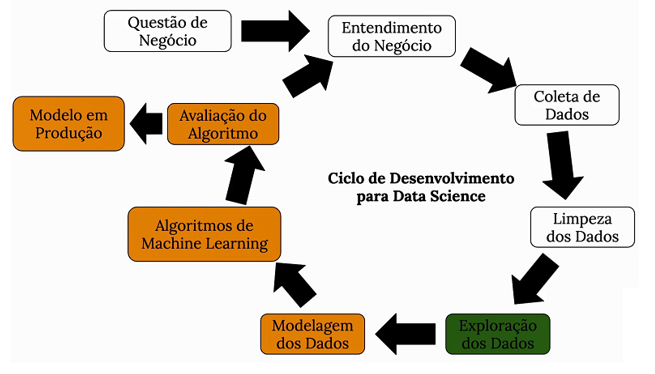

In [16]:
Image("img/crisp.png")

Métricas: <br>
* Tendência central: média, mediana
* Dispersão: variância, desvio padrão, amplitude

Embora a estatística descritiva seja compatível com dados numéricos e categóricos, a forma de construção é diferente. Portanto, preciso separar em dados numéricos e dados categóricos.

In [17]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concat
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


A seguir, alguns exemplos de distribuição das variáveis para começarmos a entender a distribuição da quantidade de registros de cada uma delas:

<AxesSubplot:xlabel='sales', ylabel='Count'>

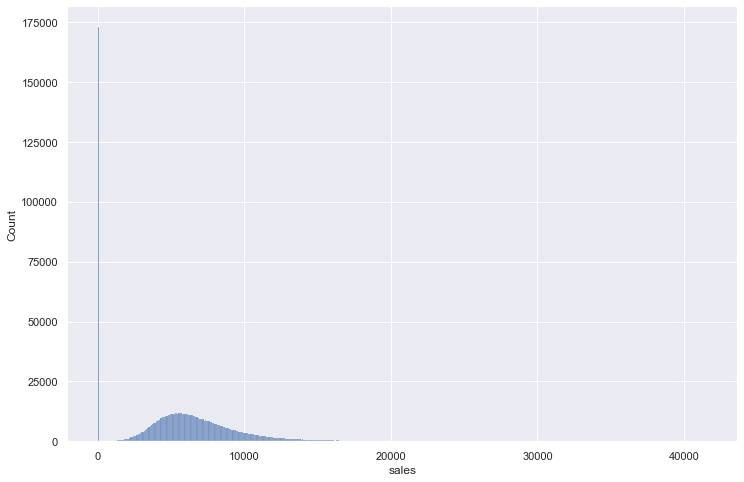

In [72]:
plt.figure(figsize=(12,8))
sns.histplot(df1["sales"]);

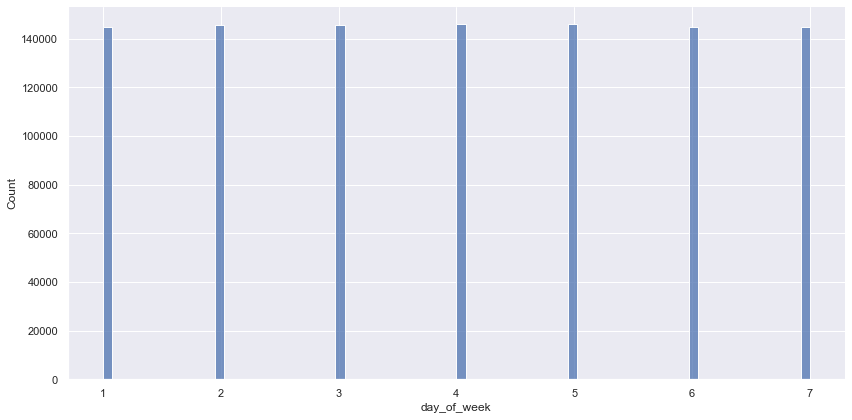

In [81]:
sns.displot(df1["day_of_week"], height=6, aspect=2);

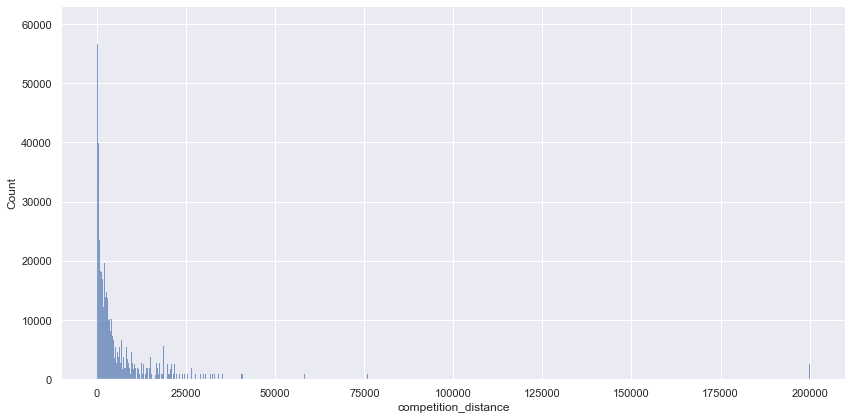

In [80]:
sns.displot(df1["competition_distance"], height=6, aspect=2);

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# outra maneira de obter o mesmo resultado
#cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

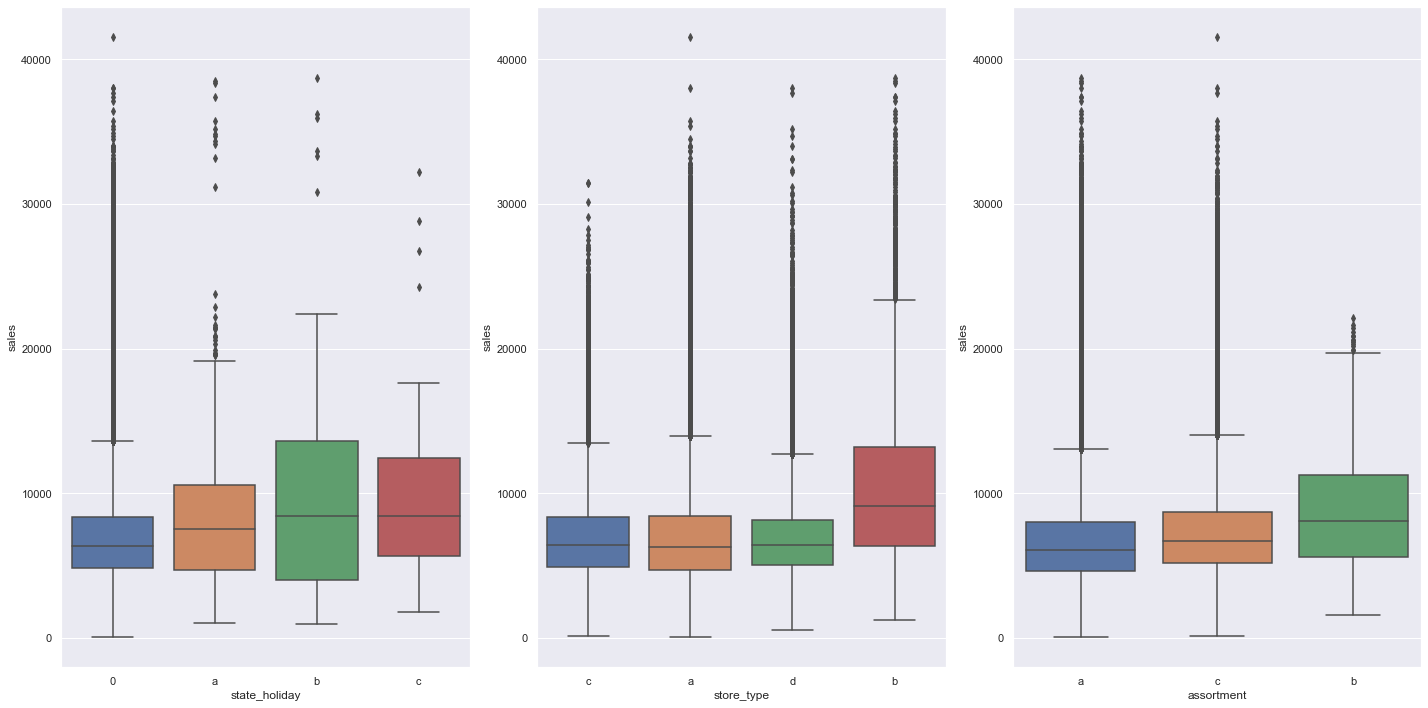

In [23]:
# desconsiderar quando as lojas estavam fechadas ou quando a venda foi nula
aux1 = df1[(df1["open"] == 1) & (df1["sales"] > 0)]
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x="assortment", y="sales", data=aux1)

plt.tight_layout()

Nos gráficos de boxplot acima, os outliers são aqueles considerados acima de 1.5  do intervalor interquartil (IQR, em inglês)
A imagem abaixo ilustra isso

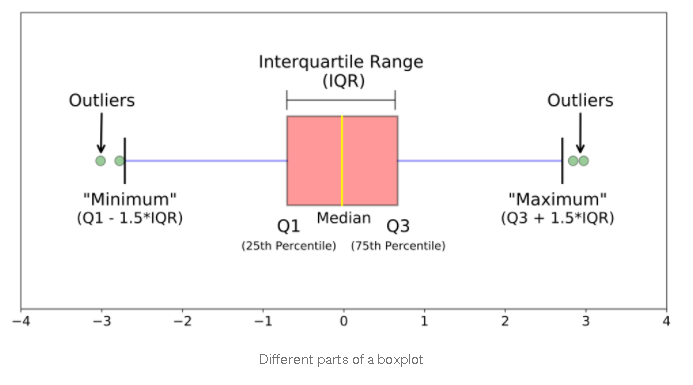

In [24]:
# fonte: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
Image("img/box_plot.png")

# 2.0 FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

Mapa mental de hipóteses:
* Fenômeno: O que estou modelando (Daily Store Sales)
* Agentes: Quais são os agentes que atuam sobre o fenômeno (cinco galhos principais)
* Atributos dos Agentes: Qual a descrição dos agentes (galhos em cada um dos agentes) <br>

O objetivo é derivar uma lista de hipóteses para podermos validá-las ou não com os dados.
Cada hipótese validada ou descartada é o insight.

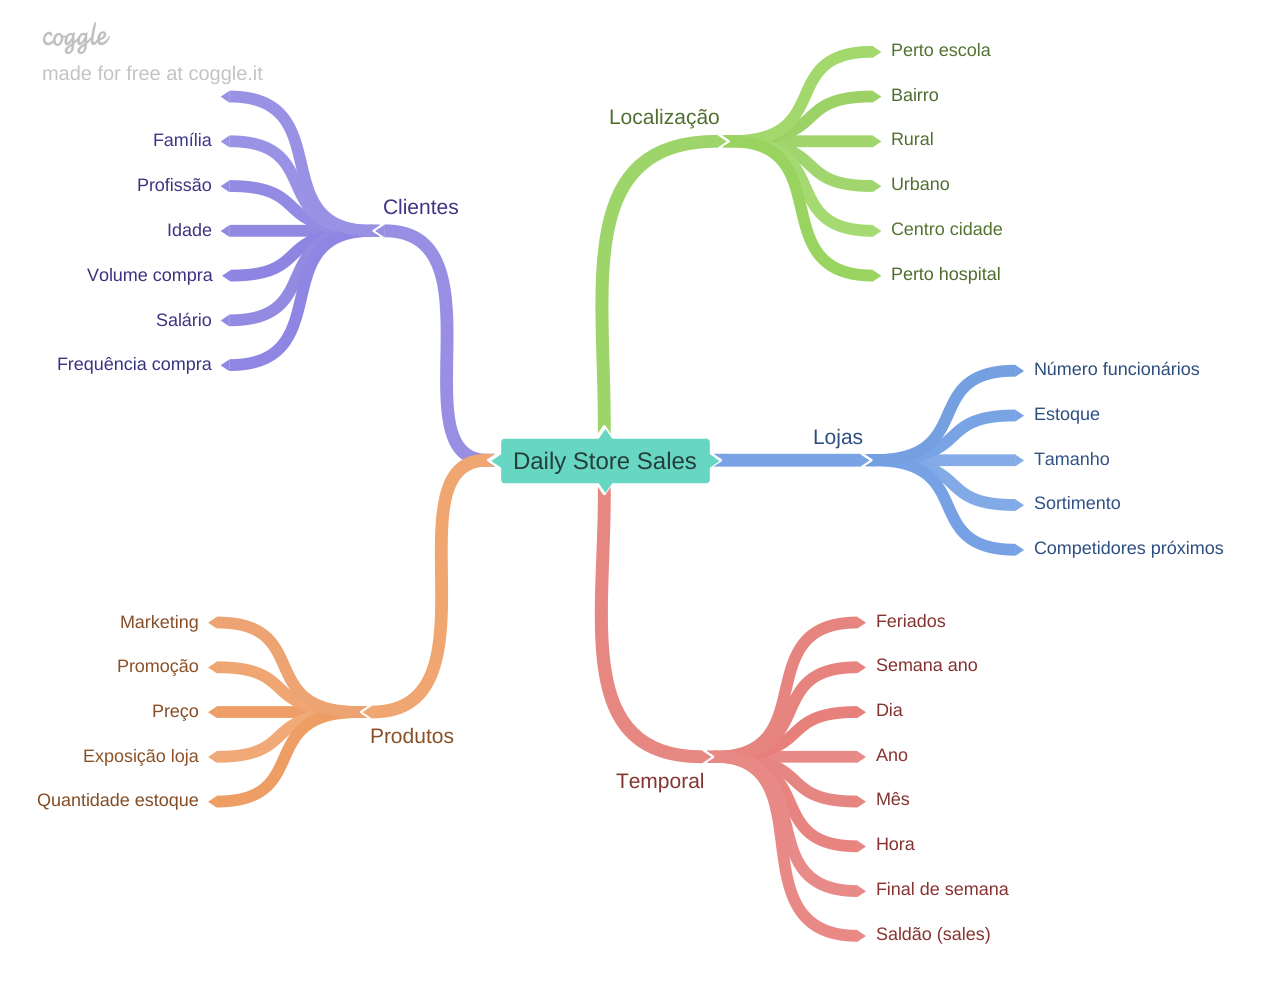

In [26]:
# gerado com ajuda de https://coggle.it/
Image("img/MindMapHypothesis.png")

O mapa mental de hipóteses acima será utilizado para extrair hipóteses para validá-las, mais a frente, durante a análise exploratória de dados.
Para escrever hipóteses, considerá-las como uma aposta, conforme os exemplos abaixo: <br>
"Lojas de MAIOR porte deveriam vender MAIS." (Repare que estou citando um atributo de um agente (Tamanho da loja) e apostando na correlação sobre a variável resposta (vendas). <br>
"Lojas de MAIOR sortimento deveriam vender MAIS." <br>
"Lojas com MAIS competidores por perto deveriam vender MENOS."


## 2.1 Criação das hipóteses

### 2.1.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais <br>
**2.** Lojas com maior estoque deveriam vender mais <br>
**3.** Lojas com maior porte deveriam vender mais (ou Lojas com menor porte deveriam vender menos) <br>
**4.** Lojas com maior sortimento deveriam vender mais <br>
**5.** Lojas com competidores mais próximos deveriam vender menos <br>
**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais <br>
**2.** Lojas que expõem mais nas vitrines da loja deveriam vender mais <br>
**3.** Lojas onde os produtos custam menos deveriam vender mais <br>
**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais <br>
**5.** Lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais <br>
**6.** Lojas com mais dias de promoção deveriam vender mais <br>
**7.** Lojas com mais promoções estendidas deveriam vender mais <br> 

### 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais <br>
**2.** Lojas deveriam vender mais ao longo dos anos <br>
**3.** Lojas deveriam vender mais no segundo semestre do ano <br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**5.** Lojas deveriam vender menos aos finais de semana <br>
**6.** Lojas deveriam vender menos durante os feriados escolares <br>
**7. (extra)** Lojas que abrem nos finais de semana deveriam vender mais <br>


## 2.2 Priorização de hipóteses

Como estamos trabalhando no método CRISP, vamos validar as hipoteses que já temos condições de verificá-las com o conjunto atual de dados obtidos. Se para a hipótese for necessário fazer mais um query no SQL, extrair, armazenar e tratar os dados, então é melhor fazer em um próximo ciclo do CRISP, caso necessário. <br>
As hipóteses abaixo foram extraídas das seções 2.1.1 a 2.1.3 pois, no dataset disponível, são as únicas que podem ser verificadas.

**1.** Lojas com maior sortimento deveriam vender mais <br>
**2.** Lojas com competidores mais próximos deveriam vender menos <br>
**3.** Lojas com competidores à mais tempo deveriam vender mais <br>

**4.** Lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais <br>
**5.** Lojas com mais dias de promoção deveriam vender mais <br>
**6.** Lojas com mais promoções estendidas deveriam vender mais <br> 

**7** Lojas abertas durante o feriado de Natal deveriam vender mais <br>
**8.** Lojas deveriam vender mais ao longo dos anos <br>
**9.** Lojas deveriam vender mais no segundo semestre do ano <br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**11.** Lojas deveriam vender menos aos finais de semana <br>
**12.** Lojas deveriam vender menos durante os feriados escolares <br>
**13. (extra)** Lojas que abrem nos finais de semana deveriam vender mais <br>

## 2.3 Feature Engineering

In [27]:
# criação de novas colunas para utilizá-las na AED e validação/refutação das hipóteses selecionadas

# year
df2["year"] = df2["date"].dt.year
# month
df2["month"] = df2["date"].dt.month
# day
df2["day"] = df2["date"].dt.day
# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week #capturar a semana do ano
# year week
df2["year_week"] = df2["date"].dt.strftime('%Y-%W')

# competition since (preciso juntar o ano e mês primeiro)
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year = x["competition_open_since_year"], month = x["competition_open_since_month"], day = 1), axis = 1)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"]) / 30).apply(lambda x: x.days).astype(int)


# promo since (queremos saber o tempo que a loja aderiu a promo2 )
# como a semana %W começa com 0, subtrai-se 7 dias
df2["promo_since"] = df2["promo2_since_year"].astype(str) +  '-' + df2["promo2_since_week"].astype(str)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

df2["promo_time_week"] = ((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

# assortment
df2["assortment"] = df2["assortment"].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})
# state holiday
df2["state_holiday"] = df2["state_holiday"].map({'a':'public_holiday', 'b':'easter_holiday', 'c':'christmas', '0': 'regular_day'})


In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [29]:
df2.state_holiday.value_counts()

regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: state_holiday, dtype: int64

# 3.0 FILTRAGEM DE VARIÁVEIS

A motivação para a filtragem de negócios são as restrições de negócio. É possível que, lá na frente, o CD se depara com a impossibilidade de colocar o modelo em produção. Isso ocorre, principalmente, devido à falta de consideração das restrições de negócio. Por isso ela é importante estar dentro do início do ciclo do CRISP. <br>
Um exemplo de restrição de negócios que foi mencionado na aula: no desenvolvimento de um projeto para previsão de vendas de um produto, verificou-se que a variável "desconto aplicado" tinha forte correlação com o volume de vendas. O modelo então foi treinado usando-se essa variável. Mas o time de negócios falou que era impossível saber o desconto antes do produto ser lançado. Logo, no momento da predição, na produção, não é possível usá-la. Por isso é importante filtrar as variáveis antes de começar o projeto em si.

In [30]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [31]:
# a coluna "open" indica se a loja está aberta (1) ou fechada (0); porém quando ela está fechada, as vendas são 0; logo não tenho nenhum aprendizado extraído das linhas onde "open" é igual a 0
# a coluna "sales" quando indica o valor 0, semelhantemente em relação à coluna "open", não há aprendizado a ser extraído, logo não usarei as linhas onde isso ocorre

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [32]:
# a coluna "customers" não temos no momento da predição; não sabemos quantos customers terão daqui 6 semanas (para isso seria necessário um outro projeto)
# também serão excluídas as colunas 'open' (que após 3.1 só apresenta o valor '1') e as colunas 'promo_interval' e 'month_map' que foram utilizadas para derivar a coluna 'is_promo'
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

Como as variáveis impactam o fenômeno & qual é a força desse impacto?

Os 3 objetivos da EDA:
- Ganhar experiência de negócio
- Validar hipóteses de negócio (insights)
    - Gerar surpresa e contrapor crenças cristalizadas empiricamente pelo time de negócios
- Perceber variáveis que são importantes para o modelo

As seguintes análises serão efetuadas na EDA:
- Análise univariada
    - Como é essa variável (min, max, range, distribuição) ?
- Análise bivariada
    - Como a variável impacta no atributo alvo (carrelação, validação das hipóteses) ?
- Análise multivariada
    - Como as variáveis se relacionam (correlação entre elas) ?

In [33]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Target variable

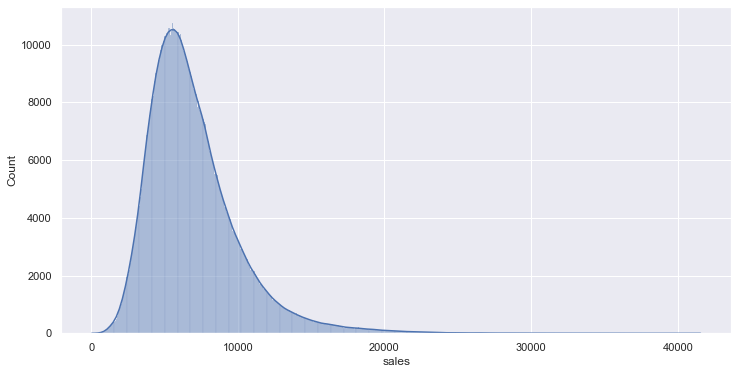

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df4['sales'], kde = True, ax = ax)
plt.show()

Uma curiosidade: foi mencionado que ao aplicar o log1p na distribuição (que não é normal) deixaria a distribuição "mais normal"; entretanto, usando o normal test do scipy não notamos diferença. Este tópico certamente será muito discutido ao longo dos meus estudos e deixo registrado aqui esta observação.
Outro método que foi mencionada para transformar a distribuição em normal é a boxcox, que também não alterou o valor do p no normaltest

In [35]:
a = (df4['sales']) 
b = np.log1p(df4['sales'])  #transf. log1p
c, _ = stats.boxcox(df4['sales']) #trans. boxcox
testes = ['a', 'b', 'c']

for teste in testes:
    k2, p = stats.normaltest(eval(teste))
    print(f'O p valor de {teste} é {p}')

O p valor de a é 0.0
O p valor de b é 0.0
O p valor de c é 0.0


### 4.1.2 Numerical variable

c:\users\rnfavar.embad.000\miniconda3\envs\dev_ds_producao\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


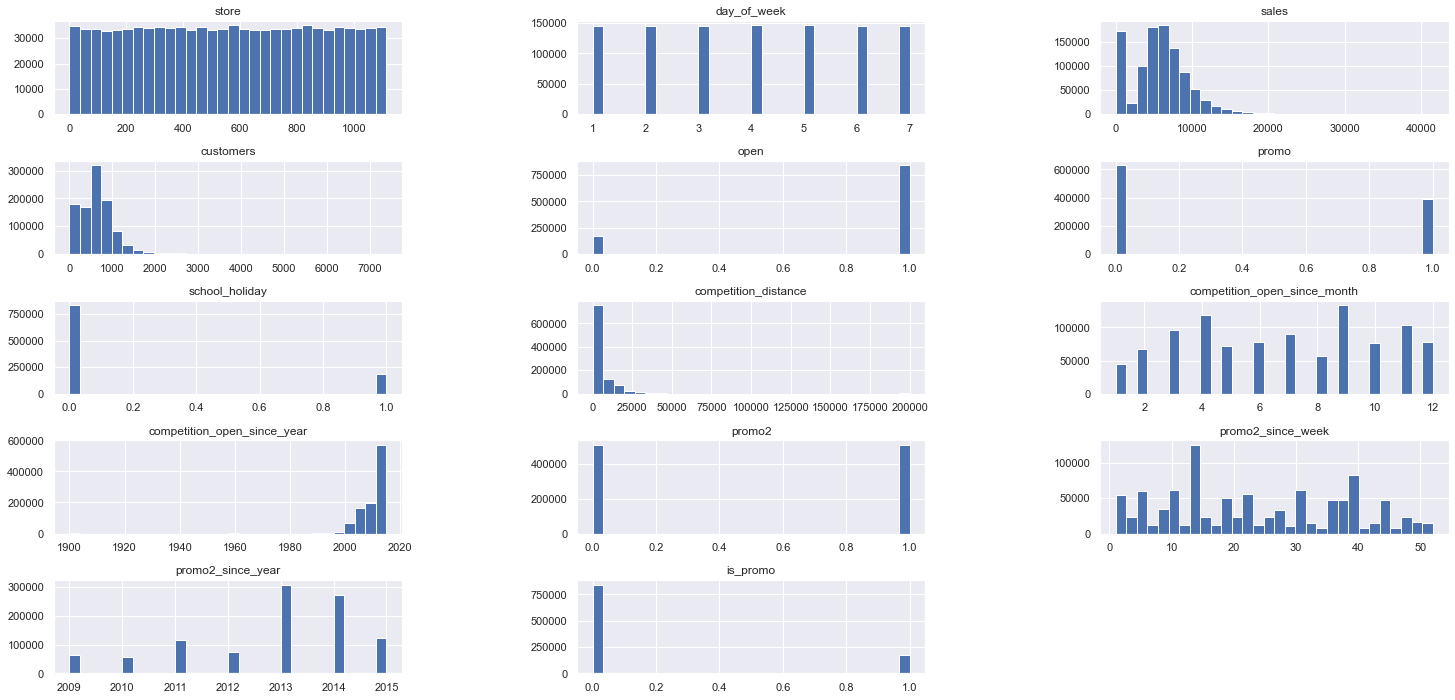

In [36]:
ax = num_attributes.hist(bins=30, figsize = (25,12), layout=(5,3));
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Algumas análises preliminares:
- o número de dados de cada loja é aproximadamente igual
- a disponibilização de dadoos de venda em cada um dos 7 dias da semana também é uniforme
- a distribuição do valor das vendas obtidos pelas diferentes lojas não segue uma distribuição normal
- a mesma distribuição das vendas parece ocorrer para o número de clientes
- a maior parte dos competidores parece que abriram em setembro, seguido por abril
- a promo2 está presente em metade dos dados disponíveis
- o ano onde mais ocorreu início da promo2 foi 2013
- a promo2 parece que tende a iniciar mais no primeiro semestre do ano (26 primeiras semanas)

### 4.1.3 Categorical variable

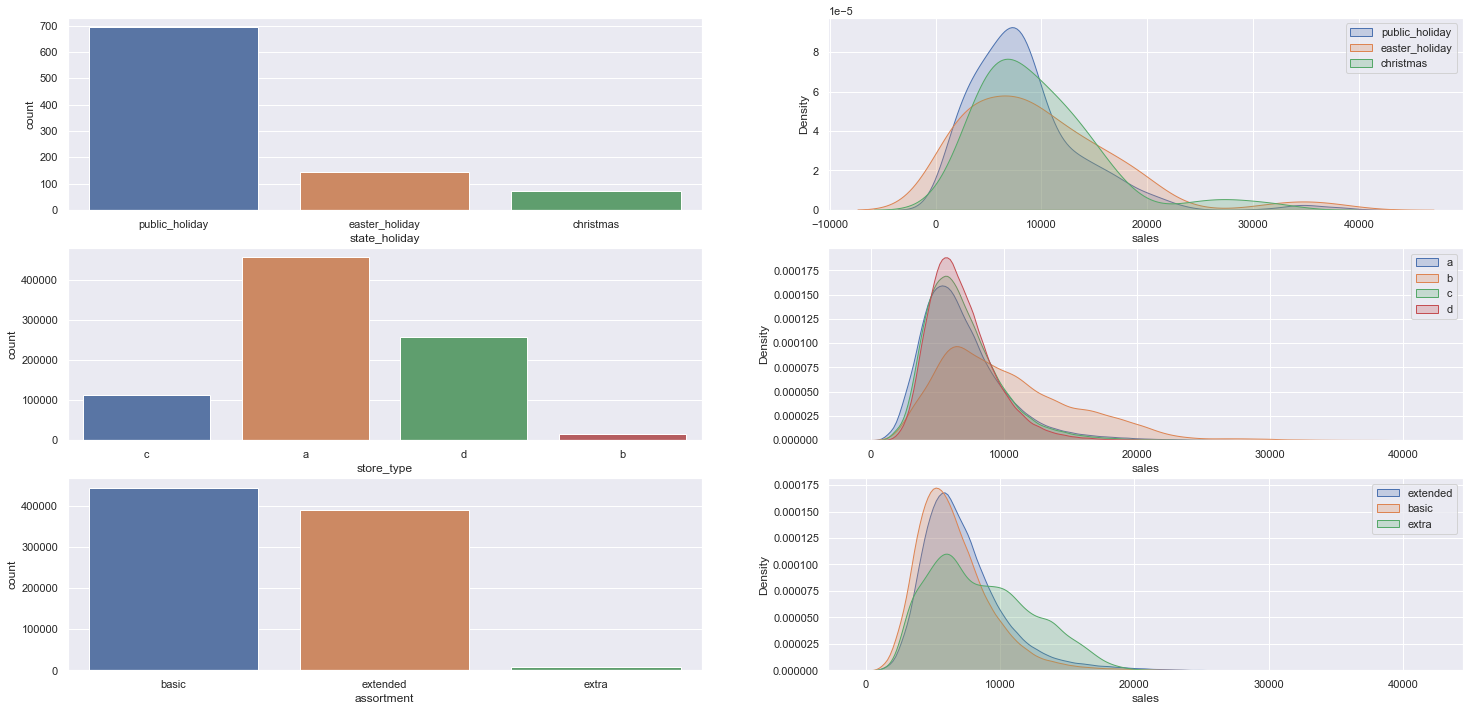

In [37]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

plt.legend()

plt.show()

Na figura acima, à esquerda, tem-se a quantidade de dados presentes para as variáveis categóricas: 'state_holiday' (excluindo-se o 'regular_day' que é a maior parte dos dados), 'store_type' e 'assortment'. Na direita, tem-se a distribuição do valor de vendas dessas mesmas variáveis categóricas em relação ao valor das vendas, já iniciando, portanto, a análise bivariada que será muito mais trabalhada na seção seguinte, com a validação ou refutação das diferentes hipóteses levantadas.

## 4.2 Análise bivariada

Todas as hipóteses priorizadas na seção 2.2 serão validadas ou refutadas nesta seção.

### H1. Lojas com maior sortimento deveriam vender mais

**verdadeira:** lojas com maior sortimento tendem a vender mais

Primeiramente, observa-se a quantidade de cada loja representante de cada sortimento.

In [38]:
df4[['store','assortment']].drop_duplicates().groupby('assortment').count()

,store
assortment,
basic,593
extended,513
extra,9


Como há considerável variação, principalmente em relação aos tipos "extra", vamos efetuar uma análise do desempenho médio por cada um desses tipos de sortimento presentes nas lojas.

In [39]:
df4[['assortment', 'sales']].groupby('assortment').describe()

sales                                                                    
               count         mean          std     min     25%     50%      75%      max
assortment                                                                              
basic       444875.0  6621.523057  2972.050174    46.0  4611.0  6082.0   8000.0  38722.0
extended    391254.0  7300.843547  3183.849717   133.0  5156.0  6675.0   8703.0  41551.0
extra         8209.0  8642.503594  3803.116031  1580.0  5606.0  8088.0  11271.0  22137.0

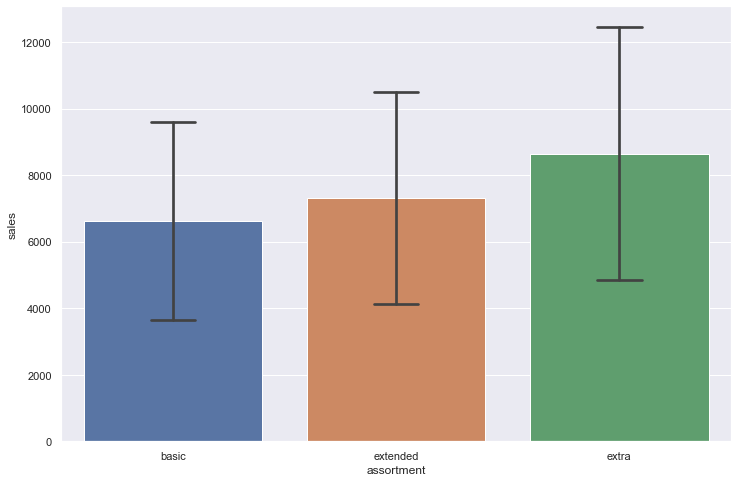

In [40]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'assortment', y='sales', data = df4, estimator = np.mean, ci = 'sd',capsize=.2);

Para investigar o efeito sazonal de tais vendas em relação aos diferentes tipos de sortimento podemos criar uma série temporal

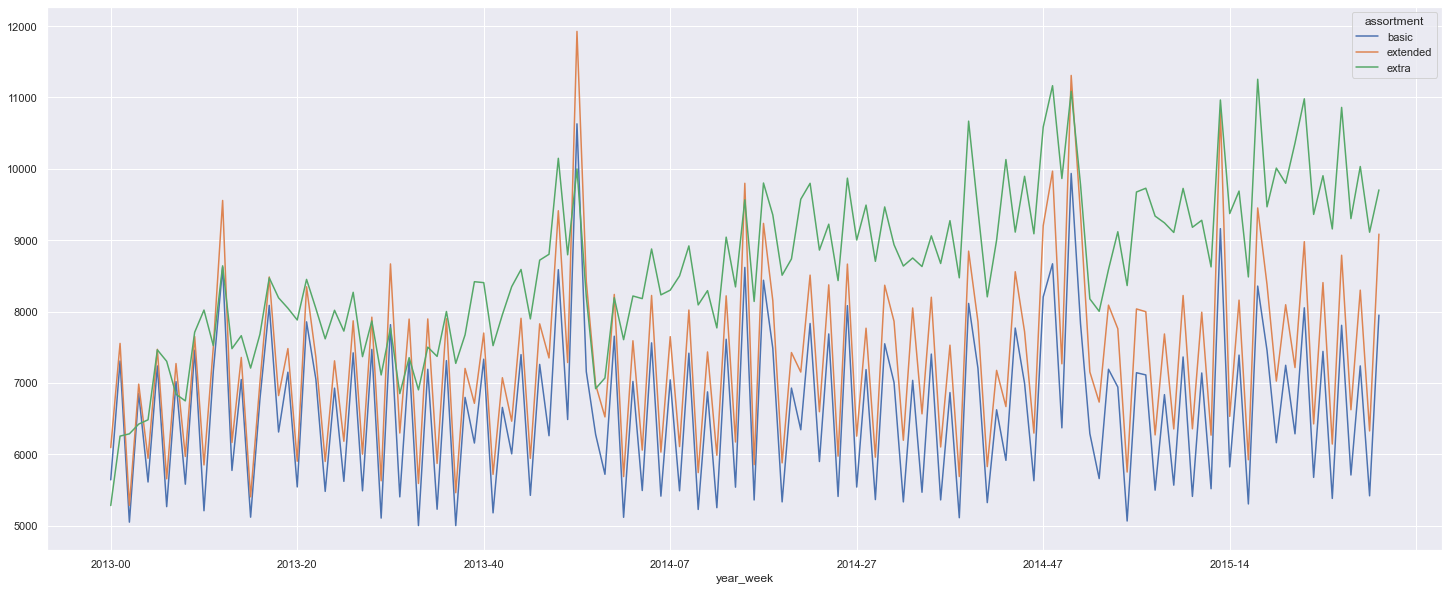

In [41]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(25,10));

Aparentemente há um descolamento do resultado de vendas obtido conforme o tempo passa para as lojas com sortimento "extra", em relação àquelas com sortimento "basic" e "extended".
Ao observar a média móvel mensal (4 semanas) fica mais nítido tal efeito.

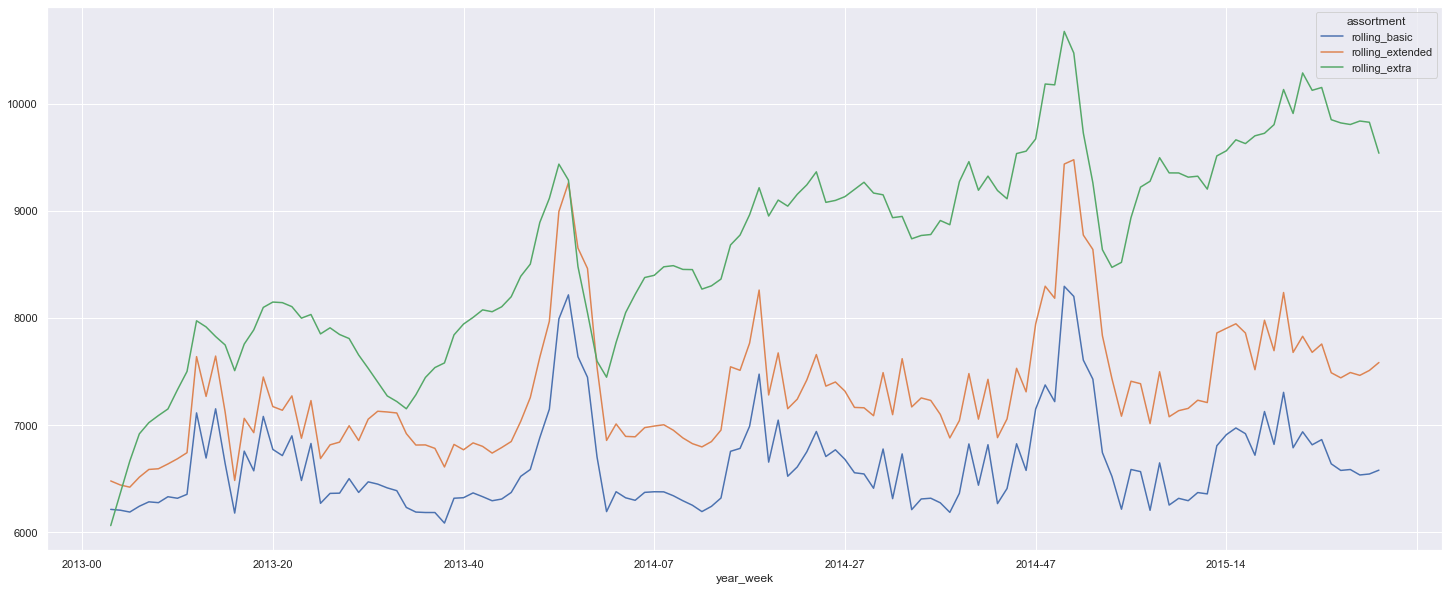

In [42]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).mean().reset_index()
aux2 = aux1.pivot(index='year_week', columns = 'assortment', values='sales').reset_index()

aux2['rolling_basic'] = aux2['basic'].rolling(4).mean()
aux2['rolling_extended'] = aux2['extended'].rolling(4).mean()
aux2['rolling_extra'] = aux2['extra'].rolling(4).mean()
aux2 = aux2.set_index('year_week')[['rolling_basic','rolling_extended','rolling_extra' ]]
aux2.plot(figsize=(25,10));


O veredito da hipótese H1 é que **"sim, lojas com maior sortimento tendem a vender mais"**

Chamo a atenção para o cuidado ao escolher a função estatística por trás de cada um desses gráficos. Na aula foi invocada a função "sum" ao invés de "mean" o que inverteu completamenet as análises:
- as vendas de lojas com sortimento "basic" pareceram maiores em relação ao sortimento "extended";
- as vendas de lojas com sortimento "extra" apareceram como sendo ínfimas

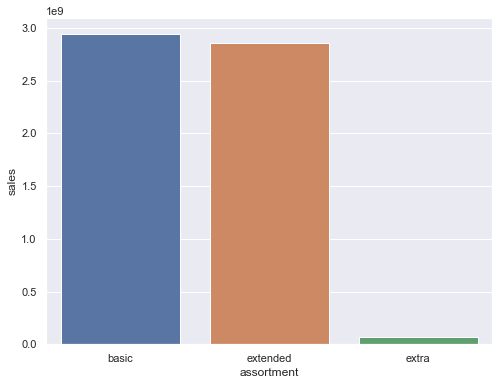

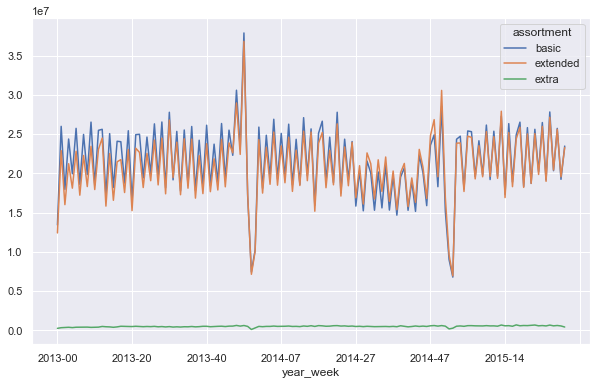

In [82]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'assortment', y='sales', data=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index());

aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux1.pivot(index='year_week', columns = 'assortment', values='sales').plot(figsize=(10,6));

### H2. Lojas com competidores mais próximos deveriam vender menos
**falsa:** não, lojas com competidores mais próximos não vendem menos (ou mais) do que as lojas com competidores mais distantes


Ao plotar o valor médio de vendas em diferentes pequenos agrupamentos de intervalo de distância tem-se a distribuição a seguir:

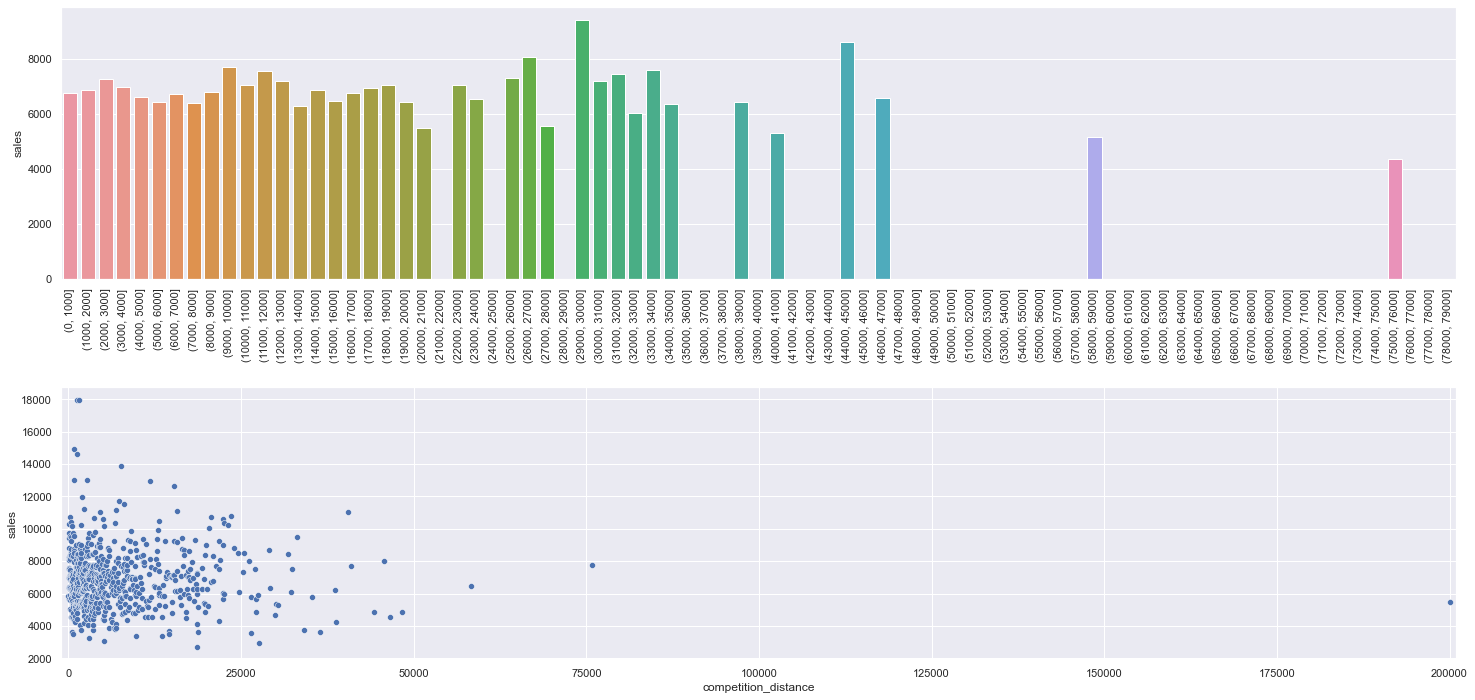

In [44]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,80000, 1000))
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()
plt.figure(figsize=(25,12))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=.4)
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xlabel("")
plt.xticks(rotation=90)

plt.subplot(2,1,2)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)
plt.xlim(-1000,201000);


Pelos gráficos acima, não há nenhuma correlação aparente entre o valor médio de vendas e a distância do competidor mais próximo. Tal observação é confirmada ao plotar o gráfico de correlação de Pearson a seguir:

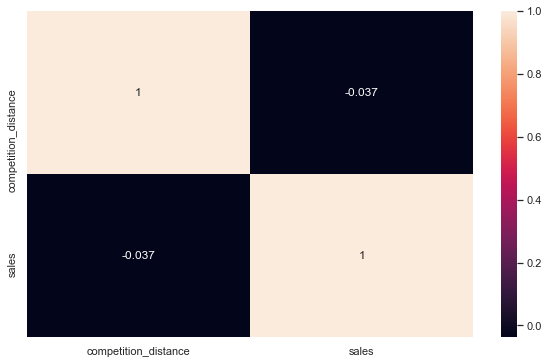

In [45]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'),annot=True);

O veredito da hipótese H2 é que **"não, lojas com competidores mais próximos não vendem menos (ou mais) do que as lojas com competidores mais distantes "**

O mesmo comentário da H1 é feito aqui: se ao invés de considerar a média for considerada a soma das vendas, as análises serão completamente diferentes

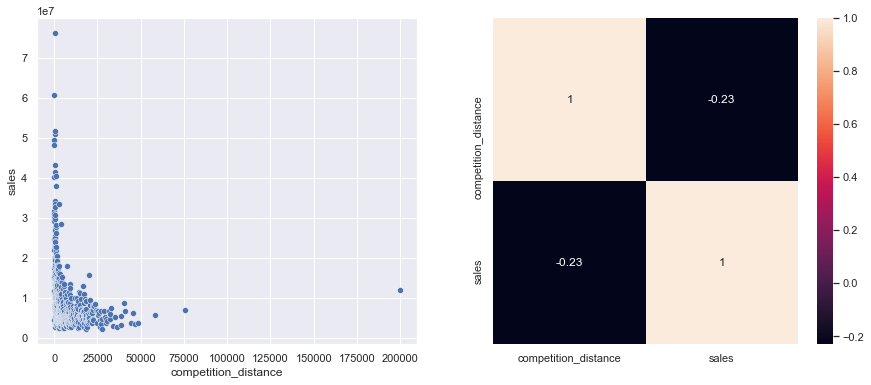

In [46]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1)

plt.subplot(1,2,2);
sns.heatmap(aux1.corr(),annot=True)
plt.show()
                

### H3. Lojas com competidores à mais tempo deveriam vender mais
**falsa:** não, lojas com competidores à mais tempo não vendem mais do que as lojas com competidores abertos mais recentemente

Ao plotar o tempo que o competidor mais próximo está aberto tem-se a distribuição a seguir:

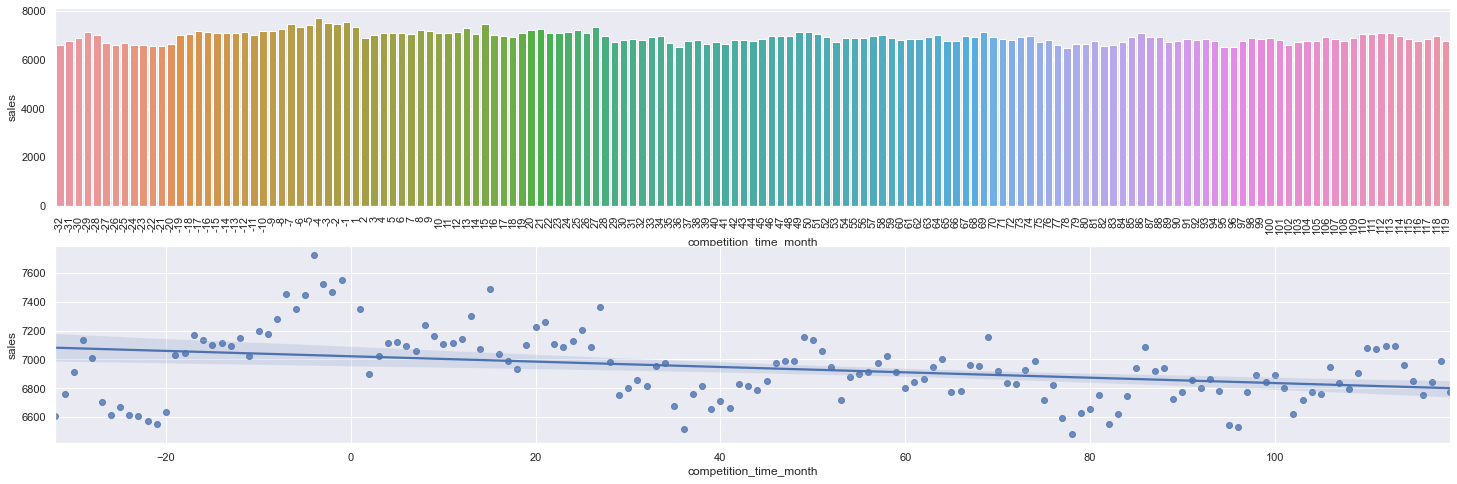

In [47]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(25,8))
plt.subplot(2,1,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,1,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

Os valores negativos devem-se aos registros de vendas antes do atual competidor mais próximo abrir.
Percebemos que há registros de tendência de maiores vendas meses antes (-12 a -1) dos competidores abrirem.
Ainda, uma vez que o competidor abre, as vendas iniciam uma tendência de queda, não sendo observado nenhuma recuperação significativa até pelo menos os 120 primeiros meses (10 anos) do competidor aberto.
Tal tendência também é sugerida na correlação de Pearson a seguir:

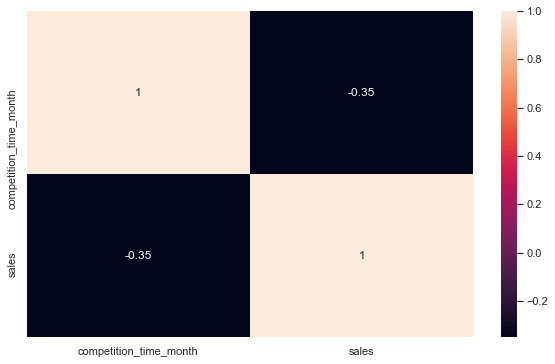

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(aux2.corr(method='pearson'),annot=True);

O veredito da hipótese H3 é que **"não, lojas com competidores à mais tempo não vendem mais do que as lojas com competidores abertos mais recentemente"**

### H4. Lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais
**verdadeira:** sim, lojas onde os produtos custam (ou já custaram) menos por mais tempo tendem a vender mais

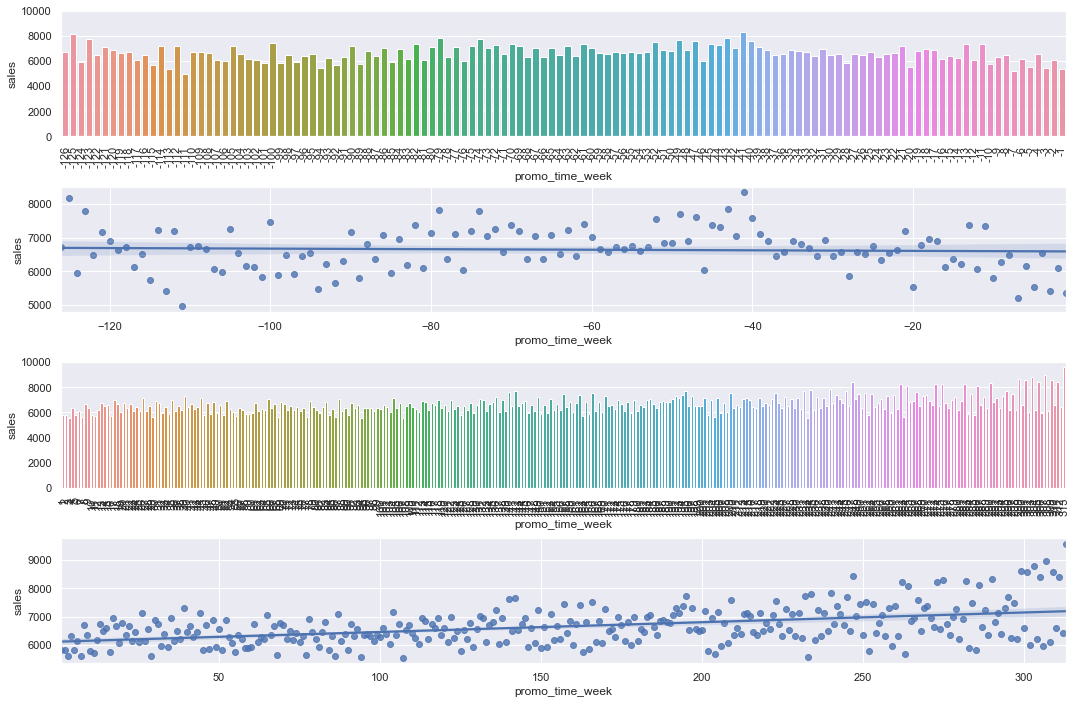

In [49]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

plt.subplot(4,1,1)
aux2 = aux1[aux1['promo_time_week'] < 0] # vendas em lojas que nunca fizeram alguma promoção estendida
plt.xticks(rotation = 90)
plt.ylim(0,10000)
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,3)
aux3 = aux1[aux1['promo_time_week'] > 0] # vendas em lojas que já fizeram alguma promoção estendida
plt.xticks(rotation = 90)
plt.ylim(0,10000)
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplots_adjust(hspace=.4)
plt.subplot(4,1,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);



Em média, as vendas que ocorreram em lojas que nunca adotaram a promo2 mostraram-se constantes; em contrapartida, as vendas que ocorreram em lojas que já adotaram alguma vez a promo2 apresenta tendência, ainda que tímida, de subida com o passar do tempo. A correlação de Pearson mostrada a seguir complementa a análise:

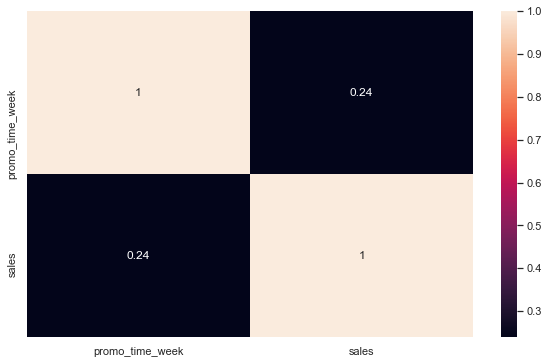

In [50]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'), annot = True);

O veredito da hipótese H4 é que **"sim, lojas onde os produtos custam (ou já custaram) menos por mais tempo tendem a vender mais"**

### <s> H5. Lojas com mais dias de promoção deveriam vender mais </s>


Como ela é muito parecida com a H4, será avaliada no próximo ciclo do CRISP

### H6. Lojas com mais promoções estendidas deveriam vender mais
**falsa:** "não, lojas que apresentam maior quantidade de promoções estendidas tendem a vender menos, em média, em comparação com lojas que apresentam apenas a promoção tradicional."

In [51]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


Em média, constata-se que as lojas que aderiram à promo1 tendem à vender mais do que a promo2 (que é a promoção estendida). A seguir, será analisado se notamos alguma mudança de comportamento com o tempo.

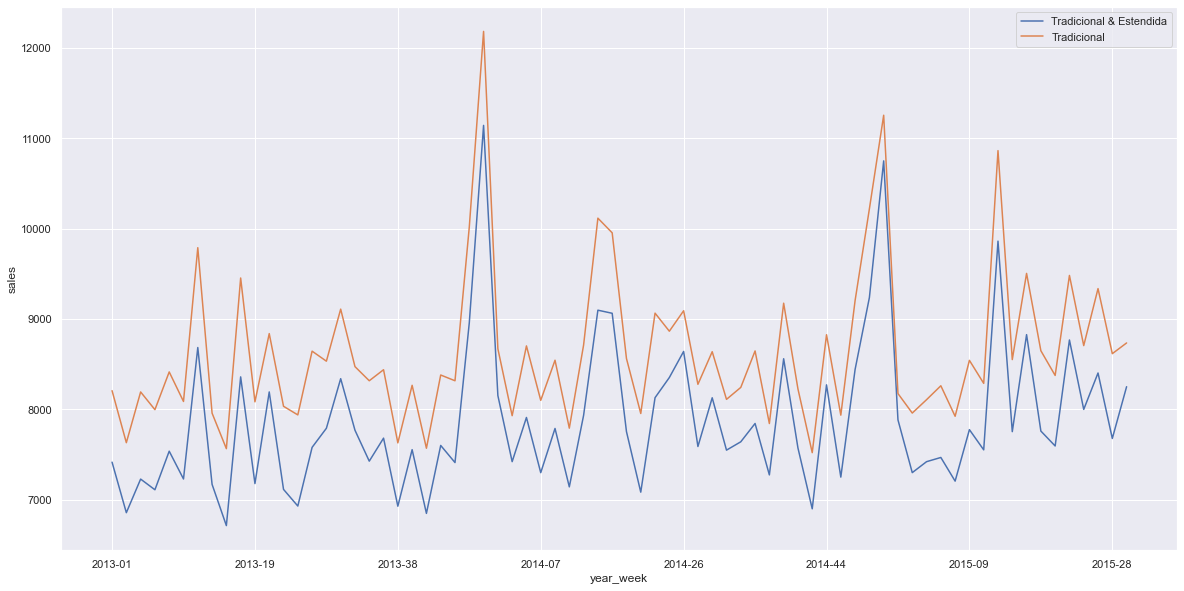

In [52]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux1.set_index('year_week',inplace=True)
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.set_index('year_week',inplace=True)
aux2.plot(ax=ax, figsize=(20,10),xlabel='year_week',ylabel='sales')

ax.legend(labels=['Tradicional & Estendida', 'Tradicional'])
plt.show()

O veredito da hipótese H6 é que "não, lojas que apresentam maior quantidade de promoções estendidas tendem a vender menos, em média, em comparação com lojas que apresentam apenas a promoção tradicional."

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais
**verdadeira:**: sim, possivelmente as vendas do Natal são mais expressivas em comparação com as vendas em feriados publicos e dias comuns, apenas perdendo ou empatando com o feriado de Páscoa.

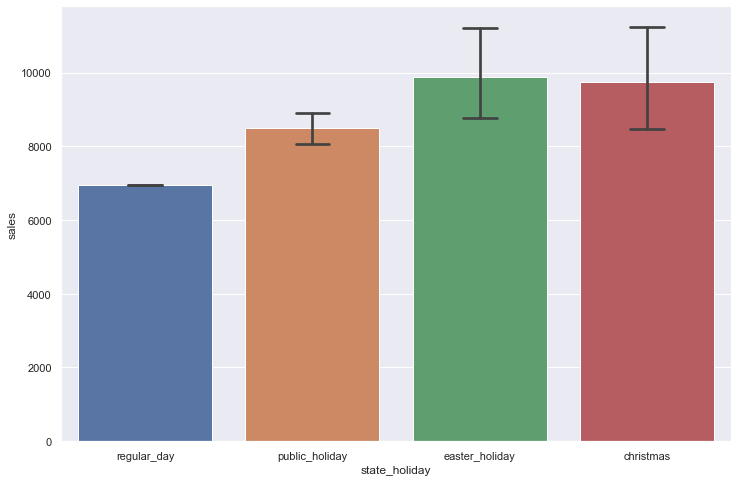

In [53]:
plt.figure(figsize=(12,8))
sns.barplot(x='state_holiday', y='sales', data=df4, estimator = np.mean, capsize=.2)
plt.show()

Nota-se que o feriado de Natal, acompanhado pelo de Páscoa, são os dois feriados onde as vendas, em média, são maiores.
A seguir, será feito análise do longo dos anos.

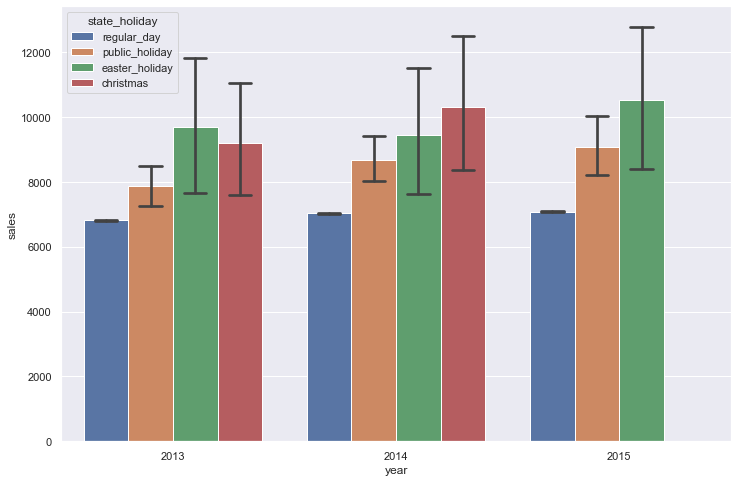

In [54]:
plt.figure(figsize=(12,8))
sns.barplot(x='year', y='sales', hue='state_holiday', data=df4, estimator = np.mean, capsize=.1)
plt.show()

Pela figura acima, aparentemente o Natal de 2014 foi mais expressivo quanto as vendas em relação ao Natal de 2013. E em 2015 é como se o ano estivesse em construção, pois o último dia dos dados é em 31/07/2015, logo antes do Natal.

O veredito da hipótese H7 é que "sim, possivelmente as vendas do Natal são mais expressivas em comparação com as vendas em feriados publicos e dias comuns, apenas perdendo ou empatando com o feriado de Páscoa."

###  H8. Lojas deveriam vender mais ao longo dos anos


**inconclusiva:** por haver apenas dados de 2 anos (2013 e 2014) sendo uma afirmação possível de se escrever é que, em média, as vendas em 2014 foram mais altas do que em 2013".

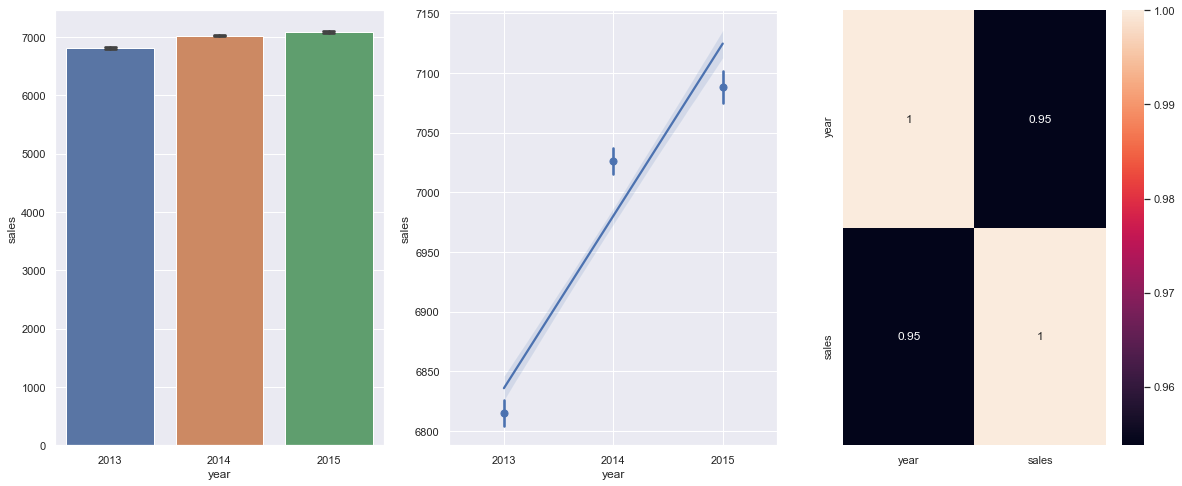

In [55]:
aux1 = df4[['year','sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(2012.5, 2015.5)
plt.xticks([2013,2014,2015])

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Há apenas 2 anos com dados de 01/01 à 31/12, que são 2013 e 2014. Portanto essa não é uma análise abrangente; em 2015, a média das vendas não está levando em consideração o segundo semestre. Podemos dizer que em, média, as lojas venderam mais em 2014 em relação à 2013. Ressalta-se ainda que dificilmente esta análise será um insight, visto que as vendas devem ser uma das métricas já acompanhadas pela empresa.

O veredito da hipótese H8 é que é "inconclusivo, por haver apenas dados de 2 anos (2013 e 2014) sendo que uma afirmação é que, em média, as vendas em 2014 foram mais altas do que em 2013".

### H9. Lojas deveriam vender mais no segundo semestre do ano
**falsa:** não é possível afirmar que há mais vendas no segundo semestre; embora a média seja ligeiramente maior, a flutuação é maior


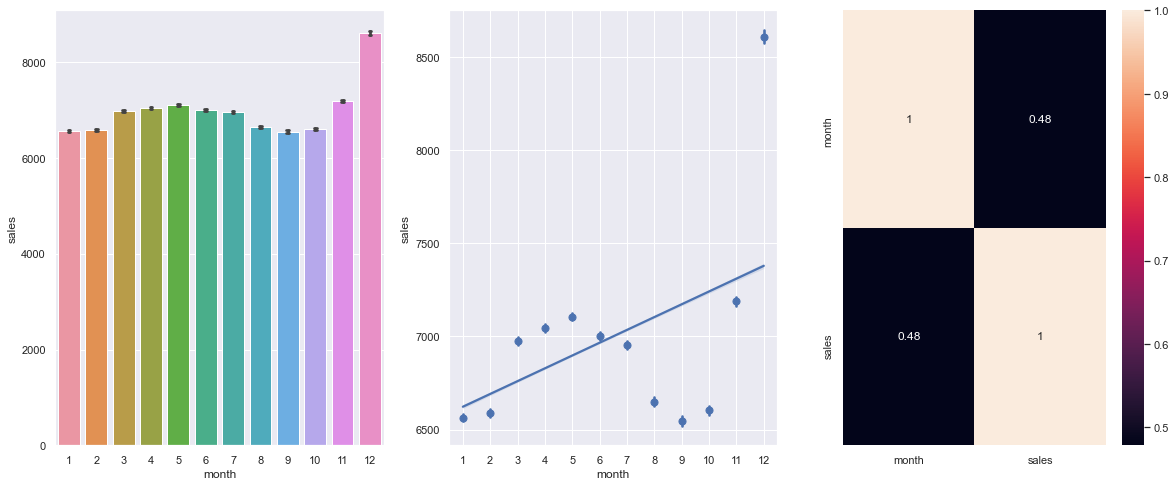

In [56]:
aux1 = df4[['month','sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 12.5)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Nota-se que o segundo semestre do ano concentram meses com baixa venda (Outubro e Novembro) e meses com altas vendas (Novembro e Dezembro)
Por enquanto é inconclusivo dizer que no segundo semestre vende mais ou menos em relação ao primeiro. Para isso pode-se fazer uma nova análise:

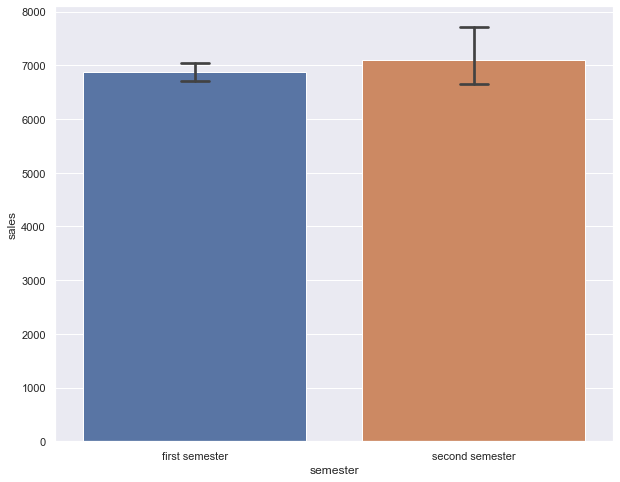

In [57]:
x = lambda x: 'first semester' if x in [1,2,3,4,5,6] else 'second semester'
aux1['semester'] = aux1['month'].apply(x)
plt.figure(figsize=(10,8))
sns.barplot(x='semester', y='sales', data=aux1, estimator = np.mean, capsize=.1)
plt.show()

O veredito da hipótese H9 é que é "falsa, visto que não é possível afirmar que há mais vendas no segundo semestre; embora a média seja ligeiramente maior, a flutuação é maior, conforme comentado previamente".

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês
**falsa:** antes do dia 10 as lojas vendem ligeiramente mais

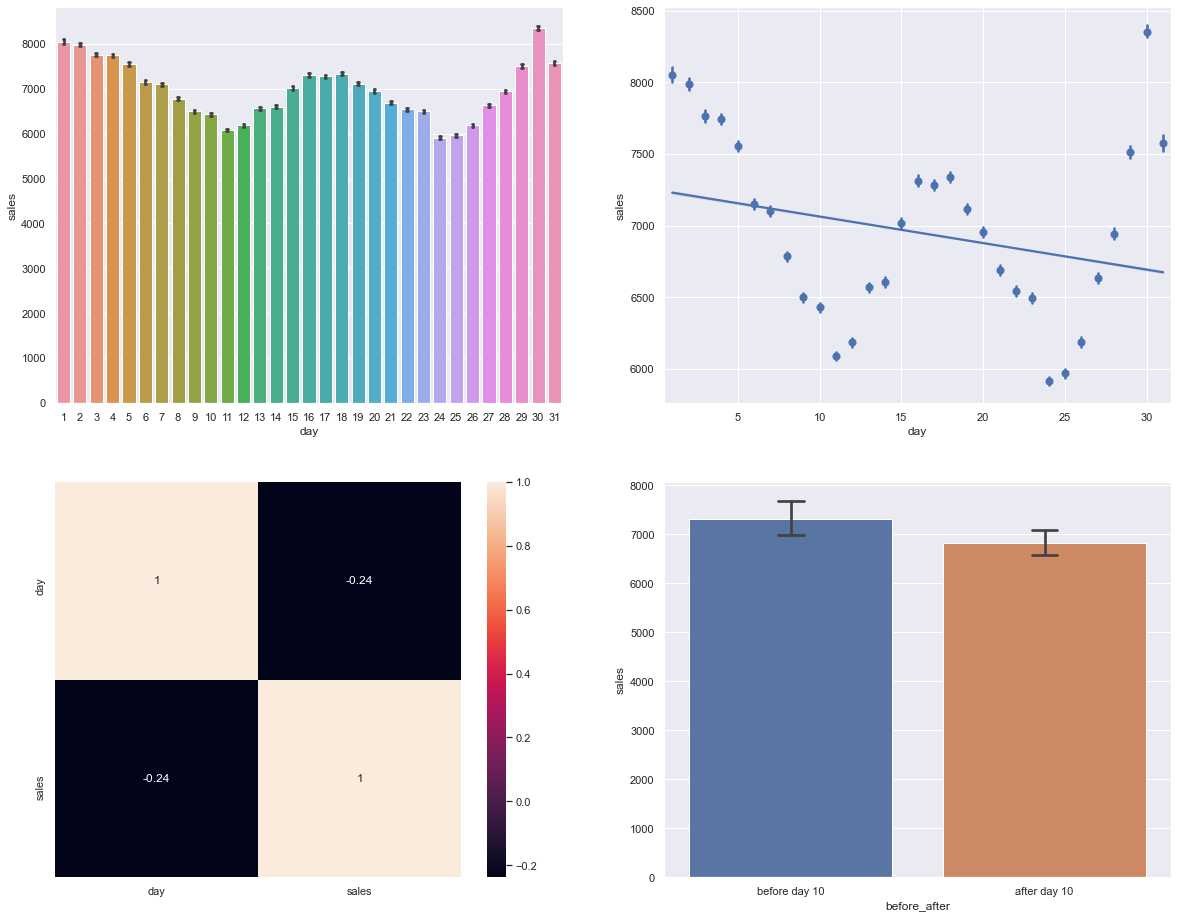

In [58]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(20,16))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 31.5)
plt.xlabel

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


x = lambda x: 'before day 10' if x <= 10 else 'after day 10'
aux1['before_after'] = aux1['day'].apply(x)
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux1, estimator = np.mean, capsize=.1)


plt.show()

Após analisar a composição dos 4 gráficos desta hipótese, nota-se que antes do dia 10, em média, as lojas vendem mais. Destaque para as vendas a partir do dia primeiro, embora relativamente altas, em queda quase constante até justamente o dia 10. Percebe-se também que as vendas aumentam mais pro final do mês.

O veredito da hipótese H10 é que é "falsa, pois antes do dia 10 as lojas vendem ligeiramente mais"

### H11. Lojas deveriam vender menos aos finais de semana
**verdadeira:** aos finais de semana, no total, as lojas vendem menos

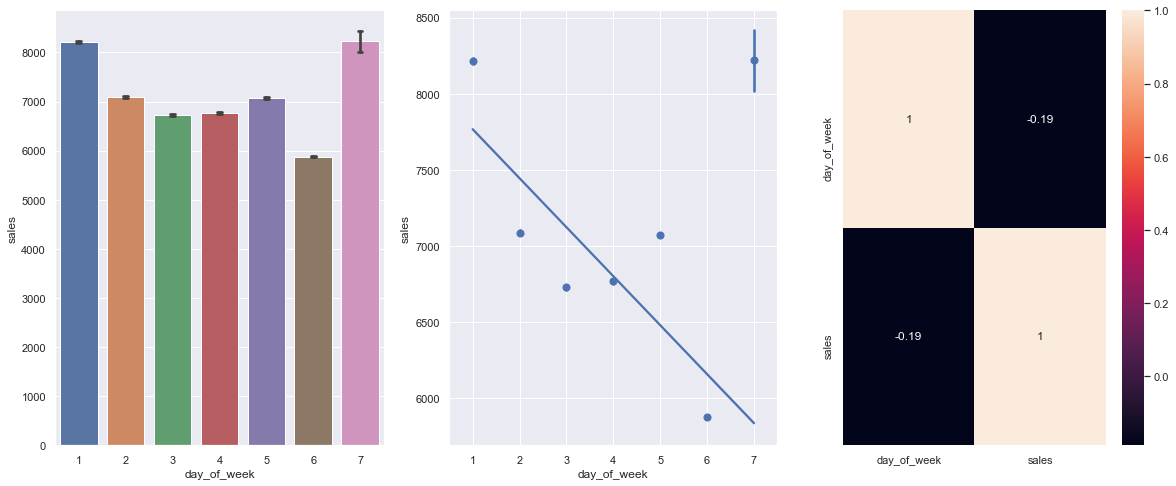

In [59]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=df4, estimator = np.mean, capsize=.1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=df4, x_estimator=np.mean)
plt.xlim(0.5, 7.5)


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

Constata-se que os finais de semana, em média, apresentam vendas menores no sábado e maiores no domingo. Mas se somarmos as contribuições das vendas de todas as lojas, percebemos que os finais de semana representam baixas vendas no total. 

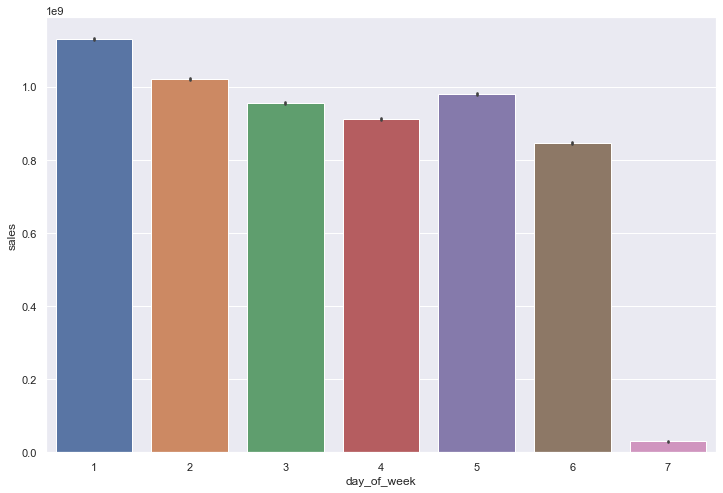

In [60]:
plt.figure(figsize=(12,8))
sns.barplot(x='day_of_week', y='sales', data=df4, estimator = np.sum)
plt.show()

Com isso, também nota-se que, se na média, o domingo é o dia da semana com as maiores vendas, mas no total é o dia que menos vende, muitas lojas não devem abrir aos domingos. Este assunto será tratado na hipótese 13.

O veredito da hipótese H11 é que é "verdadeira, pois aos finais de semana, no total, as lojas vendem menos"

### H12. Lojas deveriam vender menos durante os feriados escolares
**falsa:** nos feriados escolares as lojas vendem mais, exceto em Setembro e Dezembro.

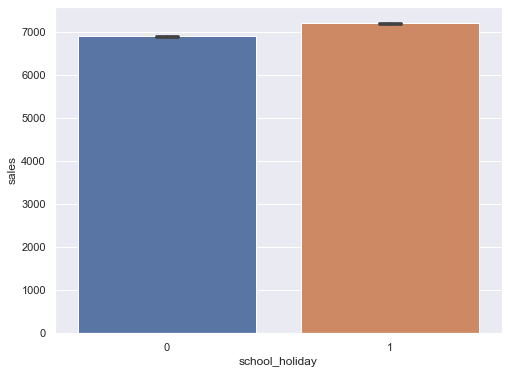

In [61]:
plt.figure(figsize=(8,6))
sns.barplot(x='school_holiday', y='sales', data=df4, estimator = np.mean, capsize=.1);

Com a análise do gráfico acima, percebe-se que nos feriados escolares, em média, vende-se mais; a seguir será feito uma análise por mês.

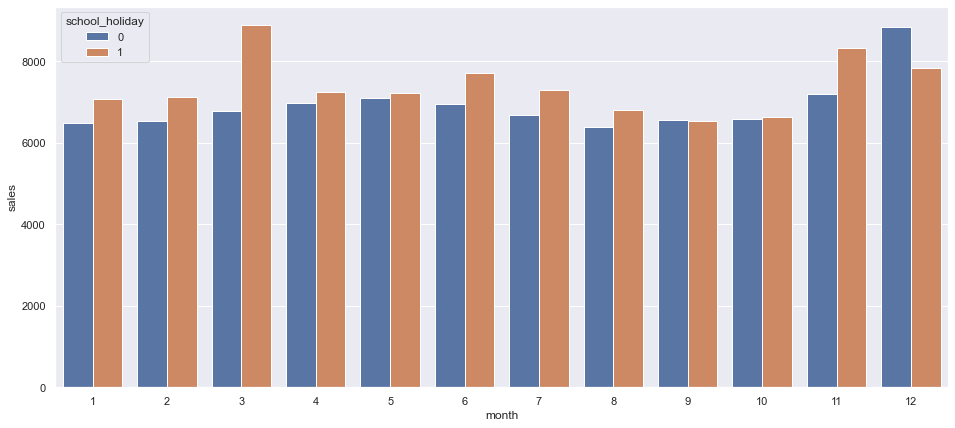

In [62]:
plt.figure(figsize=(16,7))
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x='month', y = 'sales', hue='school_holiday', data = aux1);

Nota-se que, com exceção dos meses de Setembro e Dezembro, em média vende-se mais nos feriados escolares. Destaque para as vendas dos feriados escolares de Março e Novembro.

O veredito da hipótese H12 é que é "falsa, pois nos feriados escolares as lojas vendem mais"

### H13. (extra) Lojas que abrem aos <s> finais de semana</s> domingos deveriam vender mais
**verdadeira:** lojas que abrem aos domingos vendem mais

Esta é uma hipótese extra que surgiu após a conclusão da hipótese 11. Primeiramente, há de se verificar a quantidade de lojas que abrem em cada dia da semana.

In [63]:
df4[['day_of_week','store']].groupby('day_of_week').nunique()

,store
day_of_week,
1,1115
2,1115
3,1115
4,1115
5,1115
6,1115
7,33


Após a análise da hipótese 11, o domingo é o único dia que menos lojas abrem, apenas 33. Portanto, o nome dessa hipótese deverá mudar: "Lojas que abrem aos <s> finais de semana</s> domingos deveriam vender mais."

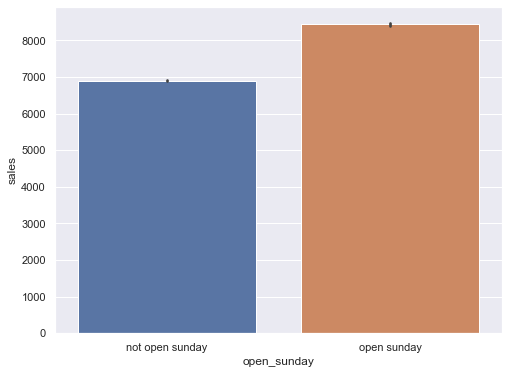

In [64]:
# captura as lojas que abrem aos domingos
stores_open_sunday = list(df4[df4['day_of_week']==7]['store'].unique())

x = lambda x: 'open sunday' if x in stores_open_sunday else 'not open sunday'
aux1 = df4[['store','sales','day_of_week']].copy()
aux1['open_sunday'] = aux1['store'].apply(x)

plt.figure(figsize=(8,6))
sns.barplot(x='open_sunday', y='sales', data=aux1, estimator = np.mean)
plt.show()

Após a análise do gráfico anterior, pode-se dizer que aquelas lojas que abrem aos domingos vendem, em média, mais do que as lojas que não abrem aos domingo. Mas para ser mais justo na comparação, vamos excluir as vendas do domingo, assim as lojas que abrem aos domingos terão o desempenho de suas vendas de segunda à sábado comparado com as vendas das lojas que não abrem aos domingos

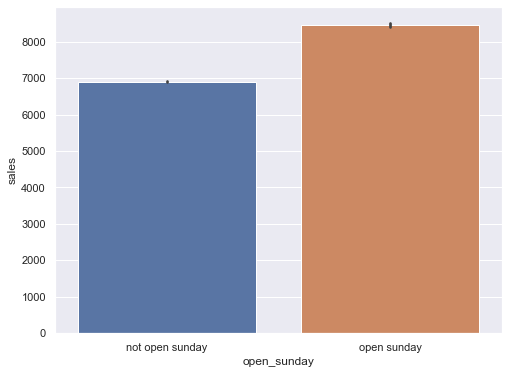

In [65]:
aux2 = aux1[aux1['day_of_week'] != 7]
plt.figure(figsize=(8,6))
sns.barplot(x='open_sunday', y='sales', data=aux2, estimator = np.mean)
plt.show()

Mesmo excluindo-se as vendas de domingo, as lojas que costumam abrir nesse dia da semana apresentam um desempenho superior em relação as lojas que não abrem aos domingos.

O veredito da hipótese H13 é que é "verdadeira, pois lojas que abrem aos domingos vendem mais".

### 4.2.1 Resumo das hipóteses

In [66]:
from tabulate import tabulate

tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1 - lojas com maior sortimento deveriam vender mais', 'verdadeira','média'],
       ['H2 - lojas com competidores mais próximos deveriam vender menos', 'falsa','baixa'],
       ['H3 - lojas com competidores à mais tempo deveriam vender mais','falsa','média'],
       ['H4 - lojas onde os produtos custam menos por mais tempo (promoções ativas) deveriam vender mais', 'verdadeira','baixa'],
       ['H5 - lojas com mais dias de promoção deveriam vender mais', 'não avaliada', '-'],
       ['H6 - lojas com mais promoções estendidas deveriam vender mais','falsa', 'alta'],
       ['H7 - lojas abertas durante o feriado de Natal deveriam vender mais', 'verdadeira', 'alta'],
       ['H8 - lojas deveriam vender mais ao longo dos anos','inconclusiva','alta*'],
       ['H9 - lojas deveriam vender mais no segundo semestre do ano', 'falsa', 'média'],
       ['H10 - lojas deveriam vender mais depois do dia 10 de cada mês', 'falsa', 'alta'],
       ['H11 - lojas deveriam vender menos aos finais de semana','verdadeira','alta'],
       ['H12 - lojas deveriam vender menos durante os feriados escolares', 'falsa', 'alta'],
       ['H13 - lojas que abrem aos domingos deveriam vender mais', 'verdadeira','alta'],       
      ]

print(tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))
print("*embora a H8 foi inconclusiva, considero de alta relevância a variável 'ano' para o modelo de Machine Learning")

╒═════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════╤══════════════╕
│ Hipóteses                                                                                       │ Conclusão    │ Relevância   │
╞═════════════════════════════════════════════════════════════════════════════════════════════════╪══════════════╪══════════════╡
│ H1 - lojas com maior sortimento deveriam vender mais                                            │ verdadeira   │ média        │
├─────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H2 - lojas com competidores mais próximos deveriam vender menos                                 │ falsa        │ baixa        │
├─────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────┤
│ H3 - lojas com competidores à mais tempo deveriam vender mais                           

## 4.3 Análise multivariada

### 4.3.1. Numerical attributes

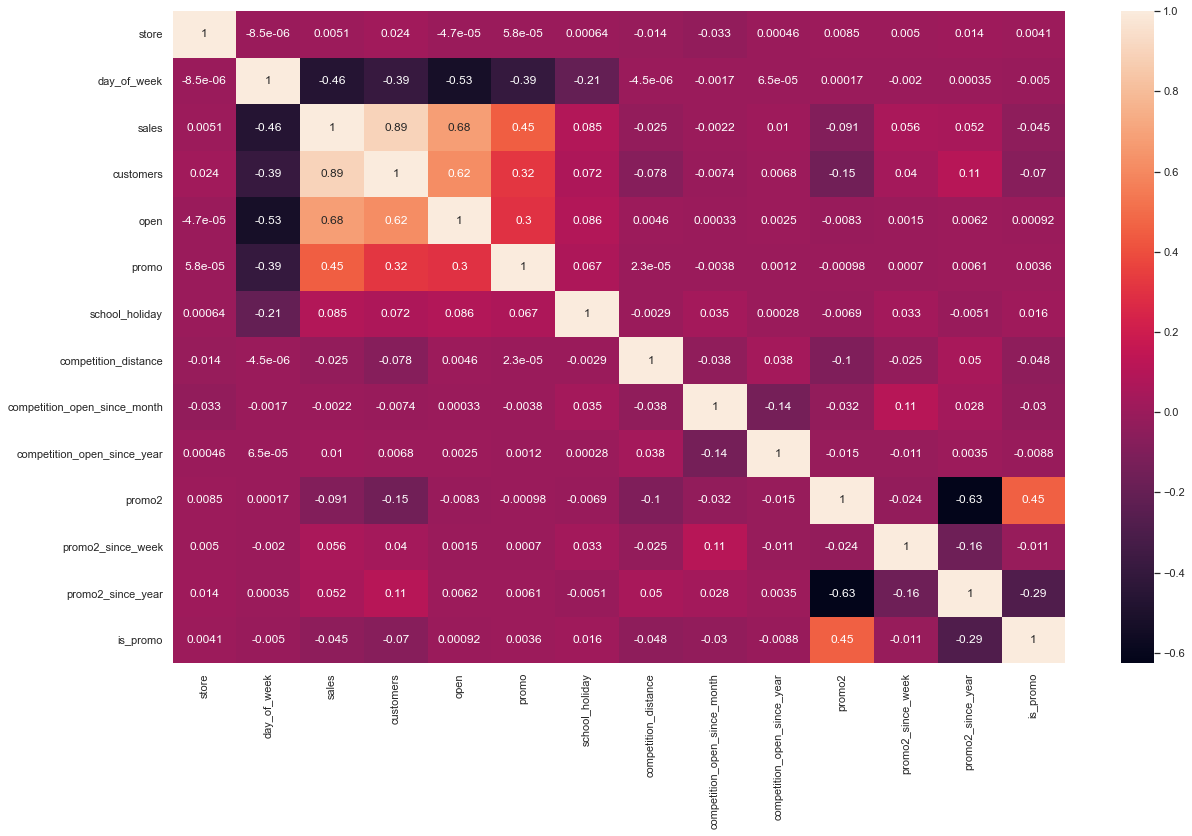

In [67]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attributes

Nesta seção é feita a análise de correção das variáveis categóricas seguindo o método de Cramér's V (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V <br>
A função foi definida na seção 0.1.

In [68]:
# seleciona apenas as colunas do tipo 'objet'
a = df4.select_dtypes(include='object')

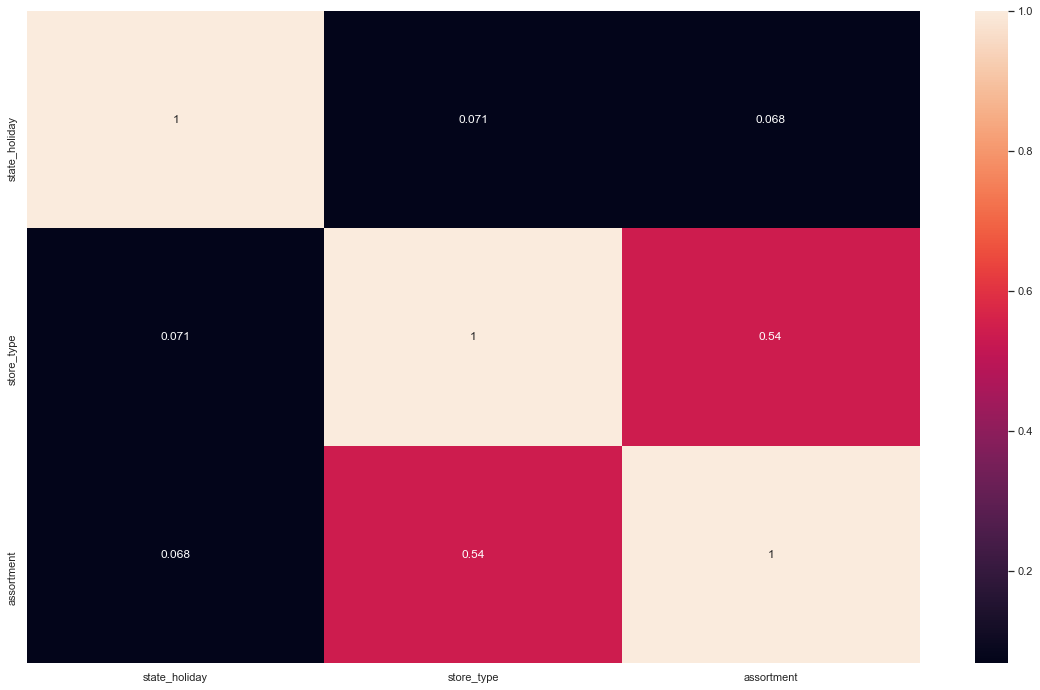

In [69]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# dataset final
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]          
             })

d = d.set_index(d.columns)
plt.figure(figsize=(20,12))
sns.heatmap(d,annot=True);

Nota-se que as variáveis 'store_type' e 'assortment' possuem razoável correlação.

In [ ]:
#teste